In [1]:
import pickle
import numpy as np
from transformations import euler_from_matrix
import matplotlib.pyplot as plt

In [2]:
robot_state_data_pickle_file_path = '/home/sony/logs/angled_slice.pkl'

In [3]:
state_dict = pickle.load( open( robot_state_data_pickle_file_path, "rb" ) )

In [4]:
def process_cartesian_trajectories(trajectory):
    
    num_trajectory_points = trajectory.shape[0]
    cartesian_trajectory = np.zeros((num_trajectory_points,6))
    cartesian_trajectory[:,:3] = trajectory[:,12:15]
    
    transformation_trajectory_1 = trajectory[:,:4].reshape((-1,4,1))
    transformation_trajectory_2 = trajectory[:,4:8].reshape((-1,4,1))
    transformation_trajectory_3 = trajectory[:,8:12].reshape((-1,4,1))
    transformation_trajectory_4 = trajectory[:,12:].reshape((-1,4,1))
    transformation_trajectory = np.concatenate([transformation_trajectory_1, transformation_trajectory_2,
                                                transformation_trajectory_3, transformation_trajectory_4], axis=2)
    
    for i in range(num_trajectory_points):
        cartesian_trajectory[i,3:] = euler_from_matrix(transformation_trajectory[i,:,:], axes='sxyz')
        #test - mult by -1
        cartesian_trajectory[i,3:] = -1*cartesian_trajectory[i,3:]
    
    return cartesian_trajectory

def make_euler_angles_continuous(trajectory):
    num_trajectory_points = trajectory.shape[0]
    
    for i in range(3,6):
        trajectory[:,i] = np.unwrap(trajectory[:,i])
    
    return trajectory         

In [5]:
def visualize_cartesian_trajectories(trajectory_times, trajectory, labels=['x','y','z','rx','ry','rz']):
    
    for i in range(6):
        if labels is None:
            plt.plot(trajectory_times, trajectory[:,i])
        else:
            plt.plot(trajectory_times, trajectory[:,i], label=labels[i])
    if labels is not None:
        plt.legend()
    plt.title('Cartesian Pose')
    plt.xlabel('Time (s)')
    plt.ylabel('Position (m) and Angle (rad)')
    plt.show()
    
def visualize_relative_cartesian_trajectories(trajectory_times, trajectory, labels=['x','y','z','rx','ry','rz']):
    
    for i in range(6):
        if labels is None:
            plt.plot(trajectory_times, trajectory[:,i] - trajectory[0,i])
        else:
            plt.plot(trajectory_times, trajectory[:,i] - trajectory[0,i], label=labels[i])
    if labels is not None:
        plt.legend()
    plt.title('Relative Cartesian Pose')
    plt.xlabel('Time (s)')
    plt.ylabel('Position (m) and Angle (rad)')
    plt.show()

In [6]:
def visualize_joint_trajectories(trajectory_times, trajectory, labels=['1','2','3','4','5','6','7']):
    
    for i in range(len(labels)):
        plt.plot(trajectory_times, trajectory[:,i], label=labels[i])
    plt.legend()
    plt.title('Joint Position')
    plt.xlabel('Time (s)')
    plt.ylabel('Position (rad)')
    plt.show()
    
def visualize_relative_joint_trajectories(trajectory_times, trajectory, labels=['1','2','3','4','5','6','7']):
    
    for i in range(len(labels)):
        plt.plot(trajectory_times, trajectory[:,i] - trajectory[0,i], label=labels[i])
    plt.legend()
    plt.title('Relative Joint Position')
    plt.xlabel('Time (s)')
    plt.ylabel('Position (rad)')
    plt.show()

In [7]:
def list_skills(state_dict):
    for key in state_dict.keys():
        skill_dict = state_dict[key]
        print(skill_dict["skill_desc"])

In [8]:
list_skills(state_dict)

ForceTorqueSkill


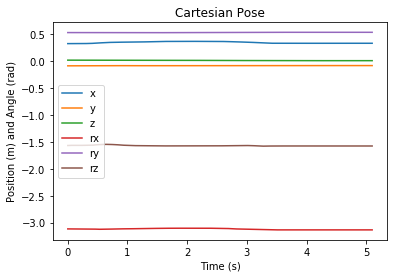

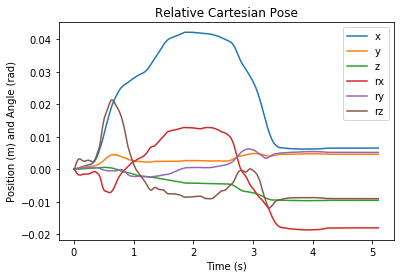

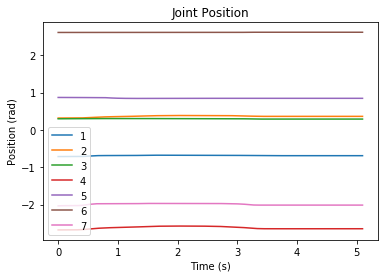

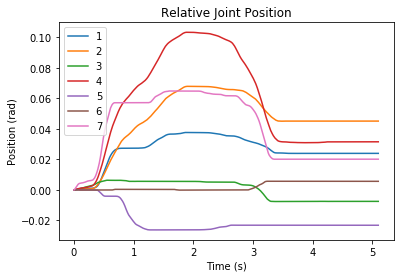

In [9]:
cartesian_trajectory = None
joint_trajectory = None

for key in state_dict.keys():
    skill_dict = state_dict[key]
    
    if skill_dict["skill_desc"] == "ForceTorqueSkill":
        skill_state_dict = skill_dict["skill_state_dict"]
        cartesian_trajectory = process_cartesian_trajectories(skill_state_dict['O_T_EE'])
        joint_trajectory = skill_state_dict['q']
        trajectory_times = skill_state_dict['time_since_skill_started']
        visualize_cartesian_trajectories(trajectory_times, cartesian_trajectory)
        visualize_relative_cartesian_trajectories(trajectory_times, cartesian_trajectory)
        visualize_joint_trajectories(trajectory_times, joint_trajectory)
        visualize_relative_joint_trajectories(trajectory_times, joint_trajectory)

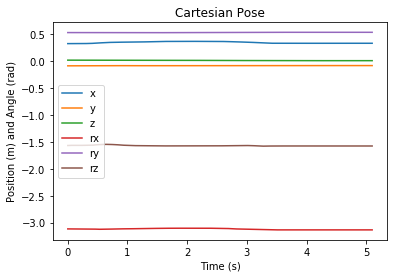

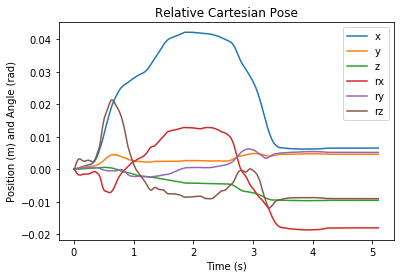

In [10]:
continuous_cartesian_trajectory = make_euler_angles_continuous(cartesian_trajectory)
visualize_cartesian_trajectories(trajectory_times, continuous_cartesian_trajectory)
visualize_relative_cartesian_trajectories(trajectory_times, continuous_cartesian_trajectory)

In [11]:
def truncate_trajectory(trajectory_times, cartesian_trajectory, joint_trajectory, threshold):
    
    num_trajectory_points = trajectory_times.shape[0]
    start_trajectory_index = 0
    end_trajectory_index = num_trajectory_points
        
    previous_robot_pose = cartesian_trajectory[0,:]
    for i in range(1,num_trajectory_points):
        current_robot_pose = cartesian_trajectory[i,:]
        if(np.linalg.norm(current_robot_pose - previous_robot_pose) > threshold):
            start_trajectory_index = i - 1
            break
        previous_robot_pose = current_robot_pose

                
    previous_robot_pose = cartesian_trajectory[-1,:]
    for i in reversed(range(0,num_trajectory_points-1)):
        current_robot_pose = cartesian_trajectory[i,:]
        if(np.linalg.norm(current_robot_pose - previous_robot_pose) > threshold):
            end_trajectory_index = i + 2
            break

    truncated_trajectory_times = trajectory_times[start_trajectory_index:end_trajectory_index]
    truncated_trajectory_times -= trajectory_times[0]
    truncated_cartesian_trajectory = cartesian_trajectory[start_trajectory_index:end_trajectory_index,:]
    truncated_joint_trajectory = joint_trajectory[start_trajectory_index:end_trajectory_index,:]
        
    return truncated_trajectory_times, truncated_cartesian_trajectory, truncated_joint_trajectory

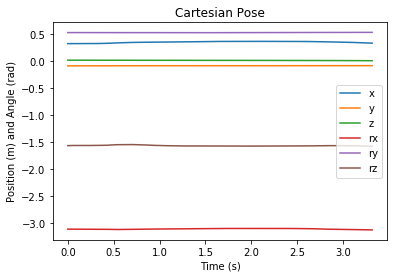

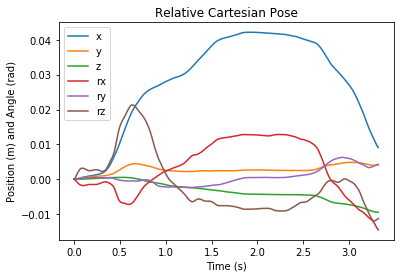

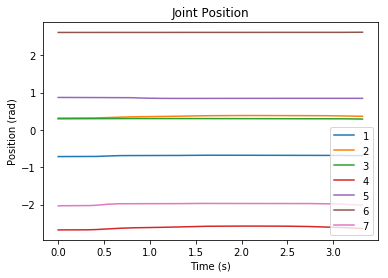

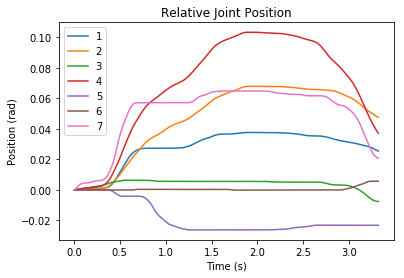

In [12]:
truncated_trajectory_times, truncated_cartesian_trajectory, truncated_joint_trajectory = truncate_trajectory(trajectory_times, continuous_cartesian_trajectory, joint_trajectory, 0.005)
visualize_cartesian_trajectories(truncated_trajectory_times, truncated_cartesian_trajectory)
visualize_relative_cartesian_trajectories(truncated_trajectory_times, truncated_cartesian_trajectory)
visualize_joint_trajectories(truncated_trajectory_times, truncated_joint_trajectory)
visualize_relative_joint_trajectories(truncated_trajectory_times, truncated_joint_trajectory)

In [13]:
np.savez(robot_state_data_pickle_file_path[:-4], trajectory_times=truncated_trajectory_times, cartesian_trajectory=truncated_cartesian_trajectory, joint_trajectory=truncated_joint_trajectory)